In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import torch
from torch.utils.data import DataLoader
from torch import nn

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../src")

from utils import rescale
from PaintingDataset import PaintingDataset

# Annotation

In [2]:
filename_ann = "../data/raw/annotation.csv"

ann = pd.read_csv(filename_ann)
ann.head()

,label,author,title,filename,width,height,label_code
0,rococo,franz-xaver-winterhalter,pincess-clothilde-von-saxen-coburg,franz-xaver-winterhalter_pincess-clothilde-von...,448,500,7
1,rococo,franz-xaver-winterhalter,anna-dollfus-baronness-de-bourgoing,franz-xaver-winterhalter_anna-dollfus-baronnes...,386,500,7
2,rococo,jean-baptiste-simeon-chardin,still-life-with-cat-and-rayfish,jean-baptiste-simeon-chardin_still-life-with-c...,398,500,7
3,rococo,william-hogarth,portrait-of-en-francis-dashwood-15th-baron-of-...,william-hogarth_portrait-of-en-francis-dashwoo...,370,500,7
4,rococo,franz-xaver-winterhalter,portrait-of-francisca-caroline-gonzaga-de-brag...,franz-xaver-winterhalter_portrait-of-francisca...,348,500,7


In [3]:
ann[["label", "label_code"]].drop_duplicates()

,label,label_code
0,rococo,7
117,japonism,4
320,cartoon,1
395,cubism,2
760,impressionism,3
1000,naturalism,5
1218,photo,6
1357,artdeco,0


In [4]:
n_classes = len(ann.label.unique())
print(n_classes)

8


# ResNet18

In [5]:
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.eval()
for param in resnet.parameters():
    param.requires_grad = False

# Dataset

In [6]:
transform = ResNet18_Weights.DEFAULT.transforms()
folder_images = "../data/raw/images"

dataset = PaintingDataset(
    ann,
    folder_images,
    transform_preprocess=transform
)

100%|██████████| 1422/1422 [00:05<00:00, 273.28it/s]


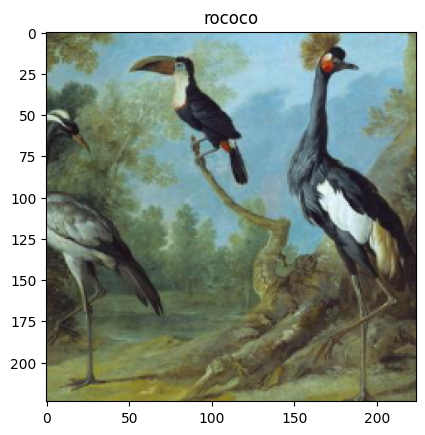

In [7]:
i = 42
x, _ = dataset[i]
label = dataset.labels[i]

plt.imshow(rescale(x.permute(1, 2, 0)))
plt.title(label);

# Dimensionality reduction

In [8]:
features = []

for x, y in tqdm(dataset):
    z = resnet(x.unsqueeze(0)).squeeze()
    features.append(z)

100%|██████████| 1422/1422 [00:20<00:00, 67.83it/s]


In [9]:
features = torch.stack(features)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [11]:
sc = StandardScaler()
pca = PCA()

pipeline = make_pipeline(sc, pca)

X = pipeline.fit_transform(features.numpy())

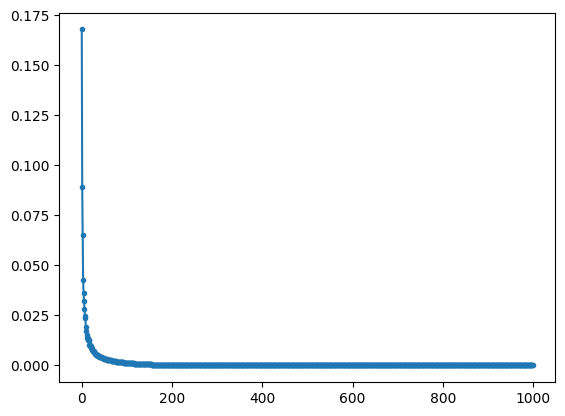

In [12]:
plt.plot(pca.explained_variance_ratio_, ".-")

In [13]:
px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=ann.label
)

In [17]:
from umap import UMAP

reducer = UMAP(n_components=3)
pipeline_umap = make_pipeline(
    StandardScaler(), reducer
)

In [18]:
X = pipeline_umap.fit_transform(features)

In [19]:
px.scatter_3d(
    x=X[:, 0],
    y=X[:, 1],
    z=X[:, 2],
    color=ann.label
)

# Conclusions

Глядя на картинки PCA и, особенно, UMAP, я думаю, что resnet18 годится для transfer learning. 

`photo` хорошо отделяется от всего.

`cubism` собирается в жирный кластер.

...